In [4]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize, brute, fmin
import matplotlib.pyplot as plt

In [5]:
# Step 1: Manually create the DataFrame using the provided option data
# The data contains Days to Maturity, Strike, Price, and Type columns

# Create a DataFrame with the manually copied data
option_data_manual = pd.DataFrame({
    'Days to maturity': [15, 15, 15, 15, 15, 60, 60, 60, 60, 60, 120, 120, 120, 120, 120,
                         15, 15, 15, 15, 15, 60, 60, 60, 60],
    'Strike': [227.5, 230.0, 232.5, 235.0, 237.5, 227.5, 230.0, 232.5, 235.0, 237.5,
               227.5, 230.0, 232.5, 235.0, 237.5, 230.0, 232.5, 235.0, 237.5, 227.5,
               230.0, 232.5, 235.0, 237.5],
    'Price': [10.52, 10.05, 7.75, 6.01, 4.75, 16.78, 17.65, 16.86, 16.05, 15.10,
              27.92, 24.12, 22.97, 21.75, 18.06, 5.20, 6.45, 7.56, 8.78, 11.03,
              12.15, 13.37, 14.75, 15.30],
    'Type': ['C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C',
             'C', 'C', 'C', 'C', 'C', 'P', 'P', 'P', 'P', 'P',
             'P', 'P', 'P', 'P']
})

# Display the first few rows to verify the data
option_data_manual.head()


,Days to maturity,Strike,Price,Type
0,15,227.5,10.52,C
1,15,230.0,10.05,C
2,15,232.5,7.75,C
3,15,235.0,6.01,C
4,15,237.5,4.75,C


In [6]:
# Step 2: Define the Heston Model and Parameters

# Define the risk-free rate (annualized)
risk_free_rate = 0.015  # 1.50%
S0 = 232.90  # Current stock price in USD

# Heston model parameters: Initial guesses for the calibration
# v0: initial variance, kappa: mean reversion speed, theta: long-term variance,
# sigma: volatility of variance, rho: correlation between asset and variance
initial_params = {
    'v0': 0.02,    # Initial variance
    'kappa': 1.5,  # Speed of mean reversion
    'theta': 0.02, # Long-term variance
    'sigma': 0.2,  # Volatility of variance
    'rho': -0.5    # Correlation between asset and variance
}

# Define the characteristic function for the Heston model based on the Lewis (2001) approach.
def heston_characteristic_function(params, u, tau):
    v0, kappa, theta, sigma, rho = params
    d = np.sqrt((kappa - 1j * rho * sigma * u)**2 + (u**2 + 1j * u) * sigma**2)
    g = (kappa - 1j * rho * sigma * u - d) / (kappa - 1j * rho * sigma * u + d)
    C = (1j * u * np.log(S0) + risk_free_rate * 1j * u * tau +
         (theta * kappa / sigma**2) * ((kappa - 1j * rho * sigma * u - d) * tau - 2 * np.log((1 - g * np.exp(-d * tau)) / (1 - g))))
    D = ((kappa - 1j * rho * sigma * u - d) / sigma**2) * ((1 - np.exp(-d * tau)) / (1 - g * np.exp(-d * tau)))
    return np.exp(C + D * v0)

# Define the Heston call price function using the characteristic function
def heston_call_price(params, K, tau):
    # Integration for price calculation using Lewis (2001) approach
    from scipy.integrate import quad

    def integrand(u):
        cf_value = heston_characteristic_function(params, u - 1j, tau)
        return np.real(np.exp(-1j * u * np.log(K)) * cf_value / (1j * u))

    integral_result = quad(integrand, 0, np.inf, limit=100)[0]
    return S0 - (np.exp(-risk_free_rate * tau) * K / np.pi) * integral_result

# Step 3: Define the error function for calibration (MSE)
def mse_error(params, option_data):
    v0, kappa, theta, sigma, rho = params
    errors = []

    for _, row in option_data.iterrows():
        # Calculate time to maturity in years (using 250 trading days assumption)
        tau = row['Days to maturity'] / 250
        K = row['Strike']
        market_price = row['Price']

        # Calculate the model price using the Heston call pricing formula
        model_price = heston_call_price((v0, kappa, theta, sigma, rho), K, tau)

        # Calculate squared error
        error = (market_price - model_price) ** 2
        errors.append(error)

    # Return the mean squared error
    return np.mean(errors)

# Step 4: Perform the optimization to calibrate the Heston model
initial_values = [initial_params['v0'], initial_params['kappa'], initial_params['theta'],
                  initial_params['sigma'], initial_params['rho']]

# Use minimize function for optimization
calibration_result = minimize(
    mse_error,
    initial_values,
    args=(option_data_manual[option_data_manual['Type'] == 'C']),  # Use only call options data for calibration
    method='L-BFGS-B',
    bounds=[(0, None), (0, None), (0, None), (0, None), (-1, 1)]
)

# Extract the optimized parameters
optimized_params = calibration_result.x
optimized_params_dict = {
    'v0': optimized_params[0],
    'kappa': optimized_params[1],
    'theta': optimized_params[2],
    'sigma': optimized_params[3],
    'rho': optimized_params[4]
}

# Display the optimized parameters
optimized_params_dict


<ipython-input-6-7eec91cb7f7c>:24: RuntimeWarning: divide by zero encountered in scalar divide
  (theta * kappa / sigma**2) * ((kappa - 1j * rho * sigma * u - d) * tau - 2 * np.log((1 - g * np.exp(-d * tau)) / (1 - g))))
<ipython-input-6-7eec91cb7f7c>:24: RuntimeWarning: invalid value encountered in scalar multiply
  (theta * kappa / sigma**2) * ((kappa - 1j * rho * sigma * u - d) * tau - 2 * np.log((1 - g * np.exp(-d * tau)) / (1 - g))))
<ipython-input-6-7eec91cb7f7c>:25: RuntimeWarning: invalid value encountered in scalar divide
  D = ((kappa - 1j * rho * sigma * u - d) / sigma**2) * ((1 - np.exp(-d * tau)) / (1 - g * np.exp(-d * tau)))
<ipython-input-6-7eec91cb7f7c>:37: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral_result = quad(integrand, 0, np.inf, limit=100)[0]
<ipython-input-6-7eec91cb7f7c>:37: IntegrationWarning: The maximum number of subdivisions (

{'v0': 1.0076231546794951,
 'kappa': 1.5008433038082303,
 'theta': 0.17684321209286863,
 'sigma': 0.199999999893155,
 'rho': -0.4999999991986624}

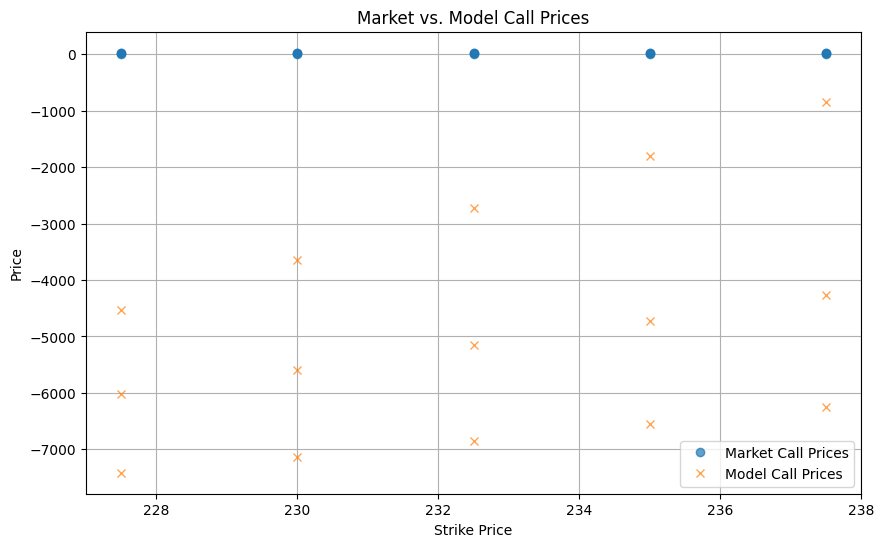

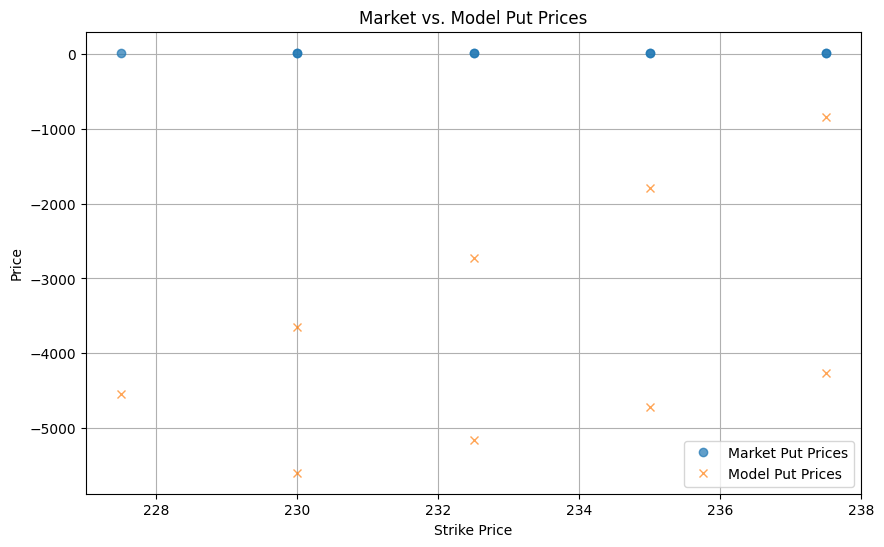

In [7]:
# Step 5: Compare Market vs. Model Prices for Call and Put options and plot the results.

# Define a function to calculate model prices for both call and put options
def calculate_model_prices(params, option_data):
    v0, kappa, theta, sigma, rho = params
    model_prices = []

    for _, row in option_data.iterrows():
        tau = row['Days to maturity'] / 250  # Convert days to years
        K = row['Strike']

        # Calculate model price using the Heston call pricing formula
        call_price = heston_call_price((v0, kappa, theta, sigma, rho), K, tau)

        # Use put-call parity for put prices: P = C + K*exp(-r*tau) - S0
        put_price = call_price + K * np.exp(-risk_free_rate * tau) - S0

        model_prices.append((call_price, put_price))

    return model_prices

# Calculate model prices for both call and put options using the calibrated parameters
model_prices = calculate_model_prices(optimized_params, option_data_manual)

# Add the model prices to the DataFrame for comparison
option_data_manual['Model_Call_Price'], option_data_manual['Model_Put_Price'] = zip(*model_prices)

# Step 6: Plot the comparison between market and model prices for calls and puts
# Filter data for plotting (e.g., calls and puts separately)
call_data = option_data_manual[option_data_manual['Type'] == 'C']
put_data = option_data_manual[option_data_manual['Type'] == 'P']

# Plot Market vs Model Call Prices
plt.figure(figsize=(10, 6))
plt.plot(call_data['Strike'], call_data['Price'], 'o', label='Market Call Prices', alpha=0.7)
plt.plot(call_data['Strike'], call_data['Model_Call_Price'], 'x', label='Model Call Prices', alpha=0.7)
plt.xlabel('Strike Price')
plt.ylabel('Price')
plt.title('Market vs. Model Call Prices')
plt.legend()
plt.grid(True)
plt.show()

# Plot Market vs Model Put Prices
plt.figure(figsize=(10, 6))
plt.plot(put_data['Strike'], put_data['Price'], 'o', label='Market Put Prices', alpha=0.7)
plt.plot(put_data['Strike'], put_data['Model_Put_Price'], 'x', label='Model Put Prices', alpha=0.7)
plt.xlabel('Strike Price')
plt.ylabel('Price')
plt.title('Market vs. Model Put Prices')
plt.legend()
plt.grid(True)
plt.show()
